# Web安全之机器学习
## 第9章 支持向量机算法
### 9.4 示例：使用支持向量机算法区分僵尸网络DGA家族

#### 1. 数据搜集和数据清洗
我们搜集如下数据集：
- 1000个cryptolocker域名；
- 1000个post-tovar-goz域名；
- alexa前1000域名。

In [1]:
import re
import matplotlib.pyplot as plt

In [2]:
def load_dga(file_crypto,file_post):
    x1 = []
    x2 = []
    with open(file_crypto,'r') as f:
        for line in f.readlines():
            x1.append(line.strip().split(',')[0])
    with open(file_post,'r') as f:
        for line in f.readlines():
            x2.append(line.strip().split(',')[0])
    return x1,x2

def load_alexa(filename):
    x3 =[]
    with open(filename,'r') as f:
        for line in f.readlines():
            x3.append(line.strip().split(',')[1])
    return x3


#### 2.特征提取
**1.元音字母的个数** 

正常的域名，通常会选择较为“好读”的字母组合，英文的元音字母比例会比较高。而DGA生成的域名字母组合较为随机。
下面来进行验证，元音字母这个特征，是否具有区分度。

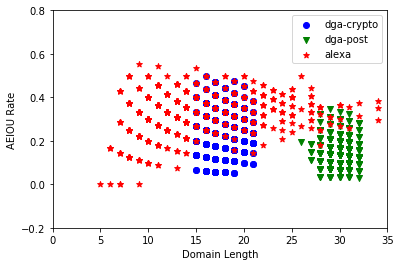

In [3]:
def get_aeiou(domin_list):
    x =[]
    y =[]
    for domin in domin_list:
        x.append(len(domin))
        pattern = re.compile("[aeiou]",re.IGNORECASE)
        count = len(re.findall(pattern,domin))
        rate = count/len(domin)
        y.append(rate)
    return x,y

def show_aeiou_feature():
    x1,x2 = load_dga("../data/dga/dga-cryptolocke-1000.txt","../data/dga/dga-post-tovar-goz-1000.txt")
    x3 = load_alexa("../data/dga/test-top-1000.csv")

    x_1,y_1 = get_aeiou(x1)
    x_2,y_2 = get_aeiou(x2)
    x_3,y_3 = get_aeiou(x3)

    plt.xlabel("Domain Length")
    plt.ylabel("AEIOU Rate")
    plt.scatter(x_1,y_1,color = 'b',label = "dga-crypto",marker='o')
    plt.scatter(x_2,y_2,color = 'g',label = "dga-post",marker='v')
    plt.scatter(x_3,y_3,color = 'r',label = "alexa",marker='*')
    plt.axis([0,35,-0.2,0.8])
    plt.legend()
    plt.show()
show_aeiou_feature()

**2.去重复后的字母数字个数与域名长度的比例**

去重后的字母数字个数与域名长度的比例，从某种程度上反映了域名字符组成的统计特征。

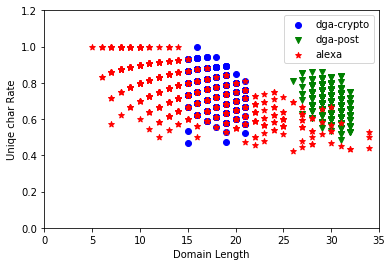

In [4]:
def get_uniq_char_rate(domin_list):
    x = []
    y = []
    for domin in domin_list:
        x.append(len(domin))
        count = len(set(domin))
        rate = count/len(domin)
        y.append(rate)
    return x,y

def show_uniq_char_feature():
    x1, x2 = load_dga("../data/dga/dga-cryptolocke-1000.txt", "../data/dga/dga-post-tovar-goz-1000.txt")
    x3 = load_alexa("../data/dga/test-top-1000.csv")

    x_1, y_1 = get_uniq_char_rate(x1)
    x_2, y_2 = get_uniq_char_rate(x2)
    x_3, y_3 = get_uniq_char_rate(x3)

    plt.xlabel("Domain Length")
    plt.ylabel("Uniqe char Rate")
    plt.scatter(x_1, y_1, color='b', label="dga-crypto", marker='o')
    plt.scatter(x_2, y_2, color='g', label="dga-post", marker='v')
    plt.scatter(x_3, y_3, color='r', label="alexa", marker='*')
    plt.axis([0, 35, 0.0 ,1.2])
    plt.legend()
    plt.show()
show_uniq_char_feature()


**3.平均jarccard系数**

jarccard系数定义为两个集合交集与并集元素个数的比值，可用于比较两个集合之间的相似度。本例是基于2-gram计算的。

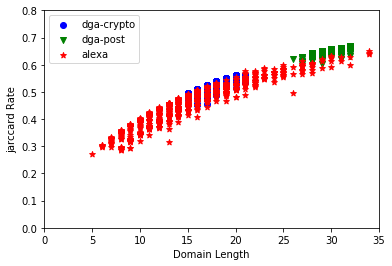

In [5]:
#计算两个域名之间的jarccard系数
def count2string_jarccard(a,b):
    x = set(' '+a[0])
    y = set(' '+b[0])
    for i in range(len(a)-1):
        x.add(a[i]+a[i+1])
    x.add(a[len(a)-1]+' ')
    for i in range(len(b)-1):
        y.add(b[i]+b[i+1])
    y.add(b[len(b)-1]+' ')
    return (0.0 + len(x-y)) / len(x|y)

## 计算两个域名集合的平均jarccard系数
def get_jarccard_index(a_list,b_list):
    x = []
    y = []
    for a in a_list:
        j = 0.0
        for b in b_list:
            j += count2string_jarccard(a,b)
        x.append(len(a))
        y.append(j/len(b_list))
    return x,y

def show_jarccard_feature():
    x1, x2 = load_dga("../data/dga/dga-cryptolocke-1000.txt", "../data/dga/dga-post-tovar-goz-1000.txt")
    x3 = load_alexa("../data/dga/test-top-1000.csv")

    x_1,y_1 = get_jarccard_index(x1,x3)
    x_2,y_2 = get_jarccard_index(x2,x3)
    x_3,y_3 = get_jarccard_index(x3,x3)

    plt.xlabel("Domain Length")
    plt.ylabel("jarccard Rate")
    plt.scatter(x_1, y_1, color='b', label="dga-crypto", marker='o')
    plt.scatter(x_2, y_2, color='g', label="dga-post", marker='v')
    plt.scatter(x_3, y_3, color='r', label="alexa", marker='*')
    plt.axis([0, 35, 0.0, 0.8])
    plt.legend()
    plt.show()
show_jarccard_feature()

**4.HMM系数**
正常的域名会偏向选取常见的几个单词组合，以英文单词训练HMM模型，正常域名的HMM系数偏高。而DGA域名是随机生成的，所以HMM系数偏低。这里只做下介绍，以后会讲。

总的来说，上面4个都可以作为特征，因为不同家族之间的具有明显的聚合效果，能有一定的区分度。